In [1]:
from etc.init import *
import etc.figureslib as lib

import NotebookScripter
from NotebookScripter import run_notebook, receive_parameter
NotebookScripter.set_notebook_option(with_matplotlib_backend=None)
savefig = receive_parameter(savefig=False)
saveext = receive_parameter(saveext='pdf')
try:
    data
except NameError:
    data = receive_parameter(data=None)

if data is None:
    data = run_notebook("Figures_load_data.ipynb")
records = data.records

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
[monochrome_palette]: value was greater than 1 and was clipped.



import copy
import os.path
import itertools
from collections import Iterable, OrderedDict, namedtuple, deque
import numpy as np
import scipy as sp
import scipy.stats
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image
from matplotlib.gridspec import GridSpec
import pymc3 as pymc
import pandas as pd
from pandas import DataFrame
from parameters import ParameterSet

from importlib import reload

import theano_shim as shim

import mackelab as ml
import mackelab.smttk as smttk
import mackelab.iotools
import mackelab.pymc3
import mackelab.parameters
import mackelab.plot
ml.parameters.Transform.namespaces['shim'] = shim

import sinn
import sinn.histories as histories
import sinn.models
from sinn.optimize.gradient_descent import FitCollection
import sinn.analyze as anlz
from sinn.analyze.axisdata import LogLikelihood, Likelihood, Probability
from sinn.analyze.axis import Axis

import fsGIF.core as core
import fsGIF.fsgif_model as fsgif_model
from fsGIF.fsgif_model

In [2]:
import seaborn as sns

---
The initial cell which imports *matplotlib* seems to initialize some settings on exit (like setting `figure.dpi` to `72`). To ensure plot styles are all applied, they should be done in a separate cell.

In [3]:
outputname = "Fig5"

In [4]:
mplconfig = run_notebook("Figures_matplotlib_config.ipynb")
inject_vars(mplconfig, globals())

In [5]:
# Micro (ground truth) simulations
#records.filter.reason('hetero').filter.script('spikes').summary.head(15)

# Meso simulations
#records.filter.script('activity').summary.head(10)

In [6]:
records.filter.reason('fig5').summary

,# records,reason,outcome,tags,main_file,avg . duration
20200209-131303,100,fig5_stepI_true-meso,,,../code/fsGIF/generate_activity.py,1h 46m 33s
20200209-131210,100,fig5_stepI_true-micro,,,../code/fsGIF/generate_spikes.py,3h 37m 56s
20200207-120342,32,fig5_stepI_true-meso,,,../code/fsGIF/generate_activity.py,1h 30m 03s
20200207-110328,100,fig5_stepI_inferred-adapt_meso,,,../code/fsGIF/generate_activity.py,1h 41m 47s
20200202-142255,100,fig5_stepI_hetero_inferred-full_meso,,,../code/fsGIF/generate_activity.py,0h 41m 10s


In [7]:
simrecords = AttrDict(
    map_adapt = lib.RecordSet('20200207-110328'),
    map_full  = lib.RecordSet('20200202-142255'),
    true_meso = lib.RecordSet('20200209-131303', '20200207-120342'),
    true_micro = lib.RecordSet('20200209-131210')
)

In [8]:
def count_recs(simrecords):
    return pd.DataFrame(
        {k: {"# records": len(rs),
             "# distinct records": len(set(ml.parameters.digest(rec.parameters)
                                       for rec in rs))
            }
          for k, rs in simrecords.items()})
count_recs(simrecords)

,map_adapt,map_full,true_meso,true_micro
# distinct records,82,100,47,58
# records,82,100,47,58


In [9]:
for rs in simrecords.values():
    rs.remove_duplicates()
count_recs(simrecords)

,map_adapt,map_full,true_meso,true_micro
# distinct records,82,100,47,58
# records,82,100,47,58


Get the lowest number of simulations for a model

In [10]:
N = count_recs(simrecords).min(axis=1)[0]

In [11]:
# Split the true_micro sims into sim and reference sets
rl = simrecords.true_micro.recordlist
i = int(len(rl)/2)
true, ref = rl[:i], rl[i:]
simrecords.true_all = simrecords.true_micro
simrecords.true_micro = lib.RecordSet(true)
simrecords.true_ref = lib.RecordSet(ref)

In [12]:
count_recs(simrecords)

,map_adapt,map_full,true_meso,true_micro,true_all,true_ref
# distinct records,82,100,47,29,58,29
# records,82,100,47,29,58,29


Prune simulation sets so that they all have the same number of sims

In [13]:
for rs in simrecords.values():
    labels = sorted(rs.records)
    rs.remove(labels[N:])

In [14]:
count_recs(simrecords)

,map_adapt,map_full,true_meso,true_micro,true_all,true_ref
# distinct records,47,47,47,29,47,29
# records,47,47,47,29,47,29


In [15]:
simtraces = lib.AxAttrs()
simtraces.start = 10.8
simtraces.end = 16.96
simtraces.dt = 0.01

In [22]:
simtraces.update({k: lib.load_traces(recs,
                                     #timelim=(simtraces.start, simtraces.end),
                                     timelim = (5.,16.96),
                                     dt=simtraces.dt,
                                     inplace=False)
                  for k,recs in simrecords.items()})

100%|██████████| 29/29 [00:01<00:00, 15.83it/s]


In [23]:
barstats = lib.BarStats(reftraces=simtraces.true_ref.traces,
                        **{model: simtraces[model].traces for model in ['true_micro', 'true_meso', 'map_adapt', 'map_full']})

---
Plot fits used to get effective time constants. These aren't used in the paper but important to check. (Uncomment and execute to see them.)

In [24]:
#lib.plot_fitcoll_grid(fig5['adapt. fit'], lib.plotdescs_2pop, ncols=3, nrows=1)

In [25]:
#pd.DataFrame({'Result': fig5['adapt. fit'].resul):t,
#              'True (log) means': lib.get_data_model_params(fitcoll_adapt)})

In [26]:
#lib.plot_fitcoll_grid(fig5['full fit'], lib.plotdescs_2pop, ncols=3)
#plt.tight_layout()

---

In [27]:
hetero_params = lib.HeteroParams(simrecords.true_micro.latest.parameters.model)

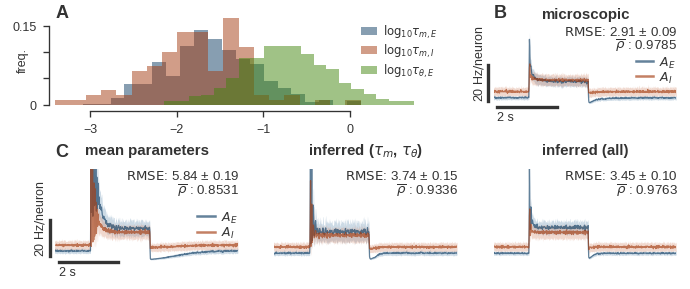

In [41]:
fig = plt.figure(figsize=(textwidth, .68*figheight))

gs = GridSpec(2,3)
gs.update(hspace=0.7, top=.95, bottom=0.1, left=0.08, right=0.98)

axes = AttrDict()
axes.paramdists = plt.subplot(gs[0,:2])
axes.true_micro = plt.subplot(gs[0,2])
axes.true_meso  = plt.subplot(gs[1,0])
axes.map_adapt  = plt.subplot(gs[1,1])
axes.map_full   = plt.subplot(gs[1,2])

# Histograms (top left)
ax = axes.paramdists
for varidx in [('τ_m', 0), ('τ_m', 1), ('τ_θ', 0)]:
    hetero_params.hist(varidx, ax=ax, transform=np.log10)

ax.set_yticks([0, .05, .10, .15])
ax.set_yticklabels(['0', '', '', '0.15'])
ax.set_ylabel("freq.", labelpad=-10)
ax.set_xticks([-3, -2, -1, 0])
xlim = ax.xaxis.get_data_interval()
ax.set_xlim(xlim[0], xlim[1]+.5)
ax.legend(['$\log_{10} τ_{m,E}$', '$\log_{10} τ_{m,I}$', '$\log_{10} τ_{θ,E}$'], bbox_to_anchor=(0.76, 0.9), fontsize=7)
#ml.plot.detach_spines(ax)
sns.despine(ax=ax, trim=True, offset=4)
ml.plot.subreflabel(ax, 'a', inside=True, y=1.1)

# Traces
ylim = (0, 50)
with mpl.style.context({'legend.labelspacing': 0}):
    ax = axes.true_micro
    linecolor=colours
    shadecolor=colours_light
    lib.plot_series_stats(simtraces.true_all, ax=ax,
                          xlim=(simtraces.start, simtraces.end), ylim=ylim, ybounds=None,
                          linecolor=linecolor, shadecolor=shadecolor,
                          zorder=imesoz, alpha=imesoα)    
    for model in ['true_meso', 'map_adapt', 'map_full']:
        ax = axes[model]
        #linecolor=[imesoc[0], tmesoc[0]]
        #shadecolor=[imesocshade[0], tmesocshade[0]]
        linecolor=colours
        shadecolor=colours_light
        lib.plot_series_stats(simtraces[model], ax=ax,
                              xlim=(simtraces.start, simtraces.end), ylim=ylim, ybounds=None,
                              linecolor=linecolor, shadecolor=shadecolor,
                              zorder=imesoz, alpha=imesoα)
    # Unlabeled axes
    for ax in [axes.map_adapt, axes.map_full]:
        ax.set_axis_off()
    # Labeled axes
    for ax in [axes.true_micro, axes.true_meso]:
        ml.plot.draw_yscale(20, "20 Hz$/$neuron", xshift=4, yshift=-4, ax=ax)
        x, y = ax.yaxis.label.get_position()
        ax.yaxis.label.set_position((x-0.08, y))
        ml.plot.draw_xscale(2, "2 s", xshift=4, yshift=0, ax=ax)
        ax.legend(['$A_{E}$', '$A_{I}$'], loc='upper right', bbox_to_anchor=(1, 0.55))
        ml.plot.set_legend_linewidth(1.5, ax)

    # Titles
    titley = .9
    axes.true_micro.set_title("microscopic", y=titley-0.2)
    axes.true_meso.set_title("mean parameters", y=titley, backgroundcolor='#FFFFFF88')
    axes.map_adapt.set_title("inferred ($\\tau_m$, $\\tau_θ$)", y=titley)
    axes.map_full.set_title("inferred (all)", y=titley)

    # Panel labels
    ml.plot.subreflabel(axes.true_micro, 'b', inside=True, y=1.1)
    ml.plot.subreflabel(axes.true_meso, 'c', inside=False, y=1.1)
    
    # RMSE & ρ
    with mpl.style.context({'font.weight': 'normal',
                            'font.size': 8}):
        for model in ['true_micro', 'true_meso', 'map_adapt', 'map_full']:
            ax = axes[model]
            Δy = 0 if model == 'true_micro' else 6
            rms = lib.trace_rms (simtraces[model], simtraces.true_ref).mean(axis=0)
            #ρ   = lib.trace_corr(simtraces[model], simtraces.true_ref).mean(axis=0)
            ρ   = np.mean(barstats.ρ[model])
            text_Δ = 1 * ml.plot.inches_to_y(mpl.rcParams['font.size'] / 72, ax=ax)
                # Font size is in points (1/72 inch)
            ax.text(17, ylim[1]-0.9*text_Δ+Δy, "$\\mathrm{{\\mathsf{{RMSE}}}}$: {:.2f} ± {:.2f}".format(*rms), ha='right', va='top',
                    zorder=4)
            #ax.text(17, ylim[1]-1.9*text_Δ, "ρ: {:.2f} ± {:.2f}".format(*ρ), ha='right', va='top',
            ax.text(17, ylim[1]-1.9*text_Δ+Δy, "$\\overline{{\\rho}}\\;$: {:.4f}".format(ρ), ha='right', va='top',
                    zorder=4)
            
assert(outputname=='Fig5')
if savefig:
    plt.savefig("figures/" + os.path.splitext(outputname)[0] + '.' + saveext.strip('.'))

In [33]:
counts = count_recs(simrecords)

---
The old method where the simulation parameters were obtained from the fit traces

    # Fits on sin input
    fitlabels = {'20180828-025657', '20180828-161410', '20180829-121721'}
    fitalllabel = {'20181022-155600'}
    truesimlabel = '20180919-201757'  # single step
    true2simlabel = '20181024-173016'  # 2nd true sim to use as reference
    input_params = 'step-input-2pop.params'
    ## Fits on target OU input
    #fitlabels = {'20180914-130232'}
    #truesimlabel = {'20180913-210255'}
    #input_params = 'brown-noise-input-2pop.params'

    fig5 = lib.FitSimCompare(
        fits = {'adapt. fit': lib.RecordSet(fitlabels),
                'full fit'  : lib.RecordSet(fitalllabel)},
        truesim      = lib.Record(truesimlabel),
        truesimref   = lib.Record(true2simlabel),
        input_params = input_params,
        avg_in_log_space = False
    )

In [ ]:
#fig5.fit_counts()

    # Set time slice to show in the traces, and set them (i.e. truncate them to that slice)
    fig5.start = 10.
    fig5.end = 17.
    fig5.dt = 0.1
    fig5.set_hists()

    fig5.μ = {}
    fig5.σ = {}

    result = fig5.fitcolls['full fit'].result
    result

```python
    fig = plt.figure(figsize=(textwidth, .63*figheight))

    ylim = (0, 50)
    titley = .7

    gs = GridSpec(2,3)
    gs.update(hspace=0.6, top=.95, bottom=0.1, left=0.08, right=0.98)

    # Histograms (top left)
    ax = plt.subplot(gs[0,:2])
    for varidx in [('τ_m', 0), ('τ_m', 1), ('τ_θ', 0)]:
        hetero_params.hist(varidx, ax=ax, transform=np.log10)
    ax.set_yticks([0, .05, .10, .15])
    ax.set_yticklabels(['0', '', '', '0.15'])
    ax.set_ylabel("freq.", labelpad=-10)
    ax.set_xticks([-3, -2, -1, 0])
    xlim = ax.xaxis.get_data_interval()
    ax.set_xlim(xlim[0], xlim[1]+.5)
    ax.legend(['$\log_{10} τ_{m,E}$', '$\log_{10} τ_{m,I}$', '$\log_{10} τ_{θ,E}$'], bbox_to_anchor=(0.76, 0.9), fontsize=7)
    ml.plot.detach_spines(ax)
    ml.plot.subreflabel(ax, 'a', inside=True, y=1.1)

    with mpl.style.context({'legend.labelspacing': 0}):

        # True trace (top right)
        ax = plt.subplot(gs[0,2])
        lib.plot_step_sim_μσ(fig5.true_a, refhist=fig5.true_a_ref, ax=ax, μ=fig5.μ, σ=fig5.σ,
                             ylim=ylim)
        ax.set_title("microscopic", y=titley)
        ml.plot.subreflabel(ax, 'b', inside=True, y=1.1)
        ax.legend(['$a_{E}$', '$a_{I}$'], loc='upper right', bbox_to_anchor=(1, 0.55))
        ml.plot.set_legend_linewidth(1.5, ax)

        # Inferred traces
        hists = [fig5.avg_hist_a, fig5.result_hists_a['adapt. fit'], fig5.result_hists_a['full fit']]
        titles = ["mean parameters", "inferred ($\\tau_m$, $\\tau_θ$)", "inferred (all)"]
        for k, (hist, title) in enumerate(zip(hists, titles)):
            ax = plt.subplot(gs[1,k])
            ax.set_title(title, y=titley)
            lib.plot_step_sim_μσ(hist, refhist=fig5.true_a_ref, ax=ax, μ=fig5.μ, σ=fig5.σ,
                                 ylim=ylim)
            if k == 0:
                ml.plot.subreflabel(ax, 'c', inside=False, y=1.)
                ax.legend(['$a_{E}$', '$a_{I}$'], loc='upper right', bbox_to_anchor=(1, 0.55))
                ml.plot.set_legend_linewidth(1.5, ax)
            else:
                ax.set_axis_off()
                pass

    assert(outputname=='Fig5')
    if savefig:
        plt.savefig("figures/" + outputname.strip('.') + '.' + saveext.strip('.'))
```

---

In [ ]:
full_fit_result = simrecords.map_full.latest.parameters.model

Values used for the result table.

In [ ]:
def reshape(a):
    if len(a) == 4: a = a.reshape((2,2))
    return a

In [ ]:
def get_means(self):
    m = {}
    for k, v in self.params.items():
        slcs = self.hetero_idcs.get(k, None)
        if slcs is not None:
            m[k] = np.array([v[slc].mean() for slc in slcs])
        else:
            m[k] = np.array(v)
    return m

In [ ]:
# TODO: print fewer digits
df = pd.DataFrame({'Inferred value': full_fit_result,
              'Average heterogeneous value': get_means(hetero_params)
             })

In [ ]:
vars_to_show = {'w', 'τ_m', 'c', 'Δu', 'τ_s', 'J_θ', 'τ_θ'}

In [ ]:
dataframe_result = df.loc[vars_to_show, :]
dataframe_result

    # TODO: print fewer digits
    pd.DataFrame({'Result': full_fit_result,
                  'True (log) means': lib.get_data_model_params(fig5.fitcolls['full fit'])})

Heterogeneous distribution parameters

In [ ]:
τmμ = hetero_params.sampler._samplers['τ_m']._pop_samplers.loc
τmσ = hetero_params.sampler._samplers['τ_m']._pop_samplers.scale
τθμ = hetero_params.sampler._samplers['τ_θ']._pop_samplers.loc
τθσ = hetero_params.sampler._samplers['τ_θ']._pop_samplers.scale

In [ ]:
index = pd.Index(['$\\log_{10} τ_{m,E}$', '$\\log_{10} τ_{m,I}$', '$\\log_{10} τ_{θ,E}$'], name='model parameter')
#columns = pd.Index(['$μ$', '$σ$'], name='distribution parameter')
df = pd.DataFrame({'$μ$': τmμ + τθμ[:1],
                   '$σ$': τmσ + τθσ[:1]}, index=index,
                    #columns=columns
                 )
dataframe_hetero_params = df
dataframe_hetero_params

In [ ]:
latex = df.to_latex(escape=False)
i = latex.find('\\toprule')
line = "{} & \\multicolumn{2}{c}{distribution parameter} \\\\\\cline{2-3} \n"
latex = latex[:i+9] + line + latex[i+9:]
latex = latex.replace('\\toprule', '').replace('\\midrule', '\\hline').replace('\\bottomrule', '\\hline')
table_hetero_params_latex = latex

In [ ]:
if __name__ == "__main__":
    print(table_hetero_params_latex)